In [11]:
import logging
import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics

from flight import federated_fit
from flight.data import federated_split, fed_barplot
from flight.topo import Topology
from flight.nn import FloxModule

from torch.utils.data import Subset
from torchvision import transforms
from torchvision.datasets import FashionMNIST

In [2]:
class SmallConvModel(FloxModule):
    def __init__(self, lr: float = 0.01, device: str | None = None):
        super().__init__()
        self.lr = lr
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.last_accuracy = None

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        preds = self.forward(inputs)
        loss = F.cross_entropy(preds, targets)
        self.last_accuracy = self.accuracy(preds, targets)
        return loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.SGD(self.parameters(), lr=self.lr)

IndexError: list index out of range

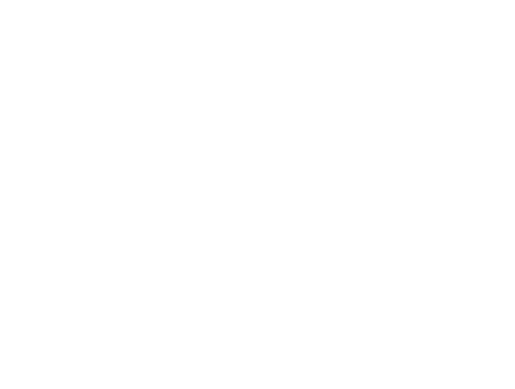

In [14]:
topo = Topology.from_yaml("flock.yaml")
topo.draw(prog="twopi")
plt.show()

In [6]:
root_dir = "~/Research/Data/Torch-Data/"
data = FashionMNIST(
    root=root_dir,
    train=True,
    download=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(0.5, 0.5)]
    ),
)
data = Subset(data, indices=list(range(1000)))
data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /Users/Nathaniel/Research/Data/Torch-Data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )